In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
import matplotlib.patches as mpatches
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from datetime import datetime
%matplotlib inline

In [2]:
'''
Everything before test year is training data
'''

test_year = 2016

'''
granularity can be single, state-wise ('state'), or county-wise('county')
'''
granularity = 'single'

In [3]:
def isCountyLevel():
    return granularity == 'county'

def isStateLevel():
    return granularity == 'state'

def isSingleLevel():
    return granularity == 'single'

In [4]:
'''
Hyperparameters, features, other important values.
'''

batch_size = 32
epochs = 5
latent = 256

'''
Size of each window
'''
window_size = 7


week = 7

len_year = 365


timeStart = 207
timeEnd = 214

linear_features =  ['TELLUSCHIN']
lstm_features = ['TELLUSCHIN', 'doy', 'TELLUSCHIN_priors']
output = ['yield']

input_file = "./US_data_modified.csv"

In [5]:
'''
Rolling prediction, uses only the data from start, then uses the model predictions to
make further predictions. 

data - 2 weeks starting data
model - lstm model to make the predictions
start, end - start dates for the predictions
rolling_prediction - vi output from rolling prediction
'''
def rollPredict(start, end, data, model, window_size, features, scale):
    i = start
    next_prediction = data.copy()
    rolling_prediction = next_prediction.flatten()[0::len(features)]
    #print(rolling_prediction)
    while i+window_size < end:
        prediction = model.predict(next_prediction.reshape(1, window_size, len(features)))
        day = next_prediction[-1][1]
        for j in range(0, window_size):
            day = ((scale*day+1)%365)/scale
            next_prediction[j][0] = prediction[0][j]
            next_prediction[j][1] = day
            next_prediction[j][2] = next_prediction[0][2]
        rolling_prediction = np.append(rolling_prediction, prediction)
        i+=window_size

    return rolling_prediction

In [6]:
'''
Prepares the LSTM with the global hyperparameters
'''
def prepareLSTM():
    model = Sequential()

    model.add(LSTM(units = latent, activation = 'tanh', input_shape = (window_size, len(lstm_features)), return_sequences = True))

    model.add(Flatten())
    
    model.add(Dense(units = window_size, activation='tanh'))

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model

In [7]:
'''
Prepare VI priors, between given start and end day
Adm2_code must be int before calling this
'''
def prepFeaturePriors(raw, feature, start, end):
    
    name = feature + '_priors'
    
    raw = raw.assign(**{name : pd.Series(np.full(len(raw['year']), 0))})
    
   
    u_counties = raw['adm2_code'].unique()
    for year in range(np.min(raw['year'].unique()) + 1, np.max(raw['year'].unique()) + 1):
        
        int_counties = np.intersect1d(raw.loc[(raw.year == year), 'adm2_code'].values, raw.loc[(raw.year == year-1), 'adm2_code'].values)
        year_counties = raw.loc[(raw.year == year), 'adm2_code'].unique()
        
        #For each county in current year
        for county in year_counties:    
            
            #if it was in the previous year, take the value
            if county in int_counties:
                feature_value = raw.loc[raw.adm2_code == county].loc[(raw.doy >= start) & (raw.doy < end)].loc[(raw.year == year-1) , feature].values
                raw.loc[(raw.adm2_code == county) & (raw.year == year) , name] = np.mean(feature_value)
                
            #else, take the value of the closest county in the previous year
            #for county level predictions

            elif (county_level):
                close_counties = np.sort(dists.loc[dists.county1 == county, 'county2'].values)
                for elem in close_counties:
                    if elem in int_counties:
                        feature_value = raw.loc[raw.adm2_code == elem].loc[(raw.doy >= start) & (raw.doy < end)].loc[(raw.year == year-1), feature].values
                        raw.loc[(raw.adm2_code == county) & (raw.year == year), name] = np.mean(feature_value)
                        break
            
            
    
    return raw

In [8]:
'''
window the data for the lstm
'''
def window(data, window_size, features):
    size = len(data)
    
    prep_data  = np.zeros([size - 2*window_size + 1, window_size, len(features)])
    prep_label = np.zeros([size - 2*window_size + 1, window_size])
    i = 0
    while i + 2*window_size <= size:
        prep_data[i] =  data[i : i+window_size]
        prep_label[i] =  data[i + window_size : i + 2*window_size].flatten()[0::len(features)]
        i+=1
    assert(len(prep_data) == len(prep_label))
    return prep_data, prep_label

In [9]:
'''
Error metrics for evaluation
'''


'''
Mean Average Percentage Error per prediction
'''
def MAPE(pred, actual):
    error = np.abs(np.array(pred) - np.array(actual))/(actual)
    return 100*np.mean(error)


'''
RMSE per prediction
'''
def RMSE(predicted, actual):
    error = ((predicted-actual)**2)
    return np.sqrt(np.mean(error))

In [10]:
'''
Basic data prep
'''
raw = pd.read_csv(input_file)


#for county level predictions
if(isCountyLevel()):
    dists = pd.read_csv("Illinois_county_dist.csv")
    raw['adm2_code'] = raw['adm2_code'].apply(lambda x : np.float32(x[4:]))


In [11]:
'''
data prep for linear model
'''
linear_raw = raw.loc[(raw.doy >= timeStart) & (raw.doy <= timeEnd)].groupby(['year', 'adm2_code']).mean().dropna().reset_index()


'''
Segment data into training and testing
'''
lin_test_data   = (linear_raw.loc[linear_raw.year == test_year, linear_features].values).reshape(-1,len(linear_features))
lin_test_label  = (linear_raw.loc[linear_raw.year == test_year, output].values).reshape(-1,len(output)).ravel()
lin_train_data  = (linear_raw.loc[(linear_raw.year < test_year), linear_features].values).reshape(-1,len(linear_features))
lin_train_label = (linear_raw.loc[(linear_raw.year < test_year), output].values).reshape(-1,len(output)).ravel()

In [12]:
'''
Specify the error metric
'''

error_metric = MAPE

In [13]:
'''
fit linear models
'''
yield_model = linear_model.LinearRegression().fit(lin_train_data, lin_train_label)

In [14]:
'''
Make predictions, calculate error on test set.
'''

yield_predicted = yield_model.predict(lin_test_data)

In [15]:
error_lr = error_metric(yield_predicted, lin_test_label)
print("Yield Prediction Error using " + str(error_metric).split()[1] + " for testing on " + str(test_year) + " in percentage = ", error_lr)

Yield Prediction Error using MAPE for testing on 2016 in percentage =  0.7796726714022808


This is the prediction accuracy for "timeStart", which is defined to be the 207 day of the year, however, 
the goal of this module is to make predictions early

In [16]:
if(isStateLevel()):
    us_area = pd.read_csv("US_Corn_Area_data.csv")
    states = (linear_raw.loc[linear_raw.year == test_year, ['adm2_code']].values).ravel()
    areas = us_area.loc[(us_area.Year == test_year) & (us_area.region.isin(reg)) & (us_area.Code.isin(states)), 'Harvest area'].values


In [17]:
'''
Save trained linear model
'''
lr_filename = "linear/" + linear_features[0] + "_"  + granularity + "_lin_yield_predictor_2_" + str(test_year) +  ".sav"
pickle.dump(yield_model, open(lr_filename, 'wb'))

In [18]:
'''
Use prepare training and testing data for lstm, validation split
is handled by keras. Only use years BEFORE test year
'''

min_year = np.min(raw['year'].unique())
raw = prepFeaturePriors(raw, linear_features[0], timeStart, timeEnd)
raw = raw.reset_index(drop=True)
raw = raw.drop(raw.loc[(raw.year == min_year)].index)
raw = raw.drop(raw.loc[raw.doy == 366].index)
raw.sort_values(['adm2_code', 'year'])
raw = raw.reset_index(drop=True)

In [19]:
'''
Normalize days to be between 0-1
'''
scale = raw['doy'].max()
raw['doy'] = raw['doy']/scale

In [20]:
'''
Create test and training dataset for LSTM
'''
def prepareLSTMdataset():
    lstm_train_data, lstm_train_labels, lstm_test_data, lstm_test_labels = [],[],[],[]
    for year in range(min_year+1, test_year+1):
        counties = raw.loc[raw.year == year, 'adm2_code'].unique()
        for county in counties:
            data = raw.loc[(raw.year == year) & (raw.adm2_code == county) & (raw.doy < year/scale), lstm_features].sort_values(['doy'])
            lstm_windowed_t, lstm_windowed_labels_t = window(data.values, window_size, lstm_features)
            if year < test_year:
                for elem in lstm_windowed_t:
                    lstm_train_data.append(elem)
                for elem in lstm_windowed_labels_t:
                    lstm_train_labels.append(elem)
            else:
                lstm_test_data.append(lstm_windowed_t)
                lstm_test_labels.append(lstm_windowed_labels_t)

    lstm_test_data = np.array(lstm_test_data).reshape((-1, window_size, len(lstm_features)))
    lstm_test_labels = np.array(lstm_test_labels).reshape((-1, window_size))
    lstm_train_data = np.array(lstm_train_data).reshape((-1, window_size, len(lstm_features)))
    lstm_train_labels = np.array(lstm_train_labels).reshape((-1, window_size))
    
    return lstm_train_data, lstm_train_labels, lstm_test_data, lstm_test_labels



lstm_train_data, lstm_train_labels, lstm_test_data, lstm_test_labels = prepareLSTMdataset()

In [31]:
'''
prepare and train lstm
'''

lstm_model = prepareLSTM()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0, verbose=0)
history = lstm_model.fit(lstm_train_data, lstm_train_labels,
                         batch_size=batch_size, callbacks=[earlyStopping], 
                         epochs=20, validation_split = 0.2)

Train on 1384 samples, validate on 347 samples
Epoch 1/20
1384/1384 [==============================] - 2s 1ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/20
1384/1384 [==============================] - 1s 734us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/20
1384/1384 [==============================] - 1s 674us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/20
1384/1384 [==============================] - 1s 671us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/20
1384/1384 [==============================] - 1s 684us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_squared_error: 0.0013


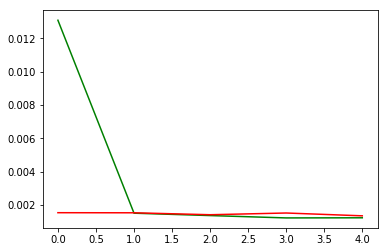

In [32]:
'''
plot training and validation curves
'''
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'r')

In [33]:
'''
Evaluate on test set for sanity check
'''
lstm_model.evaluate(lstm_test_data, lstm_test_labels)

345/345 [==============================] - 0s 165us/step


[0.0012894161382143426, 0.0012894161382143426]

In [34]:
'''
Feature prediction sanity check
'''
real_mean = np.array([])
pred_mean = np.array([])
day = 1
len_year = 365
inc = len_year - 2*window_size + 1

for start in range(0, len(lstm_test_data), inc):
    end = start+inc
    first_window = (lstm_test_data[start+day]).copy()
    rolling_prediction = rollPredict(start+day, end, first_window, lstm_model, window_size, lstm_features, scale)
    test_set = lstm_test_data[start+day:end+week].flatten()[0::window_size][0::len(lstm_features)]
    real_mean = np.append(real_mean, np.mean(test_set[timeStart-day:timeEnd-day]))
    pred_mean = np.append(pred_mean, np.mean(rolling_prediction[timeStart-day:timeEnd-day]))

In [35]:
print("Error : ", error_metric(pred_mean, real_mean))

Error :  92.27942698817638


error for predicted mean value of CHI - 

In [26]:
'''
save models in respective directories 
'''

lstm_filename = 'LSTM/' + linear_features[0] + "_" + granularity + '_with_priors_2_' + str(test_year) + '.h5'
lstm_model.save(lstm_filename)


If you have pretrained models, use these to load them, along with the test_year

eg -

test_year = 2017


lstm_model = load_model('LSTM/mod_evi2county_with_priors_2_2017.h5')

yield_model = pickle.load(open('Linear/mod_evi2_County_lin_yield_predictor_2_2017.sav', 'rb'))



In [27]:
'''
code for the combined model
'''

def combined_model(start_day):

    result_array = []
    model_error = []
    model_predictions = []
    
    test_raw = raw.loc[(raw.year == test_year) & (raw.doy >= start_day/scale) & (raw.doy <= (start_day + window_size)/scale), 
                       ['adm2_code'] + lstm_features + output]
    

    test_raw = test_raw.sort_values(['adm2_code','doy']).reset_index(drop=True)
    
    
    for idx in range(0, len(test_raw), window_size):
        result =  np.mean(test_raw[idx:idx+window_size][output].values)
        result_array.append(result)

        #this was added because the raw data is missing feature values for some days.
        if(len(test_raw[idx:idx+window_size][lstm_features].values) % 7 != 0):
            continue
            
        window_vi =  test_raw[idx:idx+window_size][lstm_features].values.reshape(1, window_size, len(lstm_features))
        rolling_vi = rollPredict(start_day, timeEnd, window_vi[0], lstm_model, window_size, lstm_features, scale)
        vi_mean = np.mean(rolling_vi[timeStart-start_day:timeEnd-start_day])
        prediction = yield_model.predict([[vi_mean]])
        model_predictions = np.append(model_predictions, prediction[0])
        
    return result_array, model_predictions

In [28]:
error = []
model_predictions = []
result_array = []
first_day = 1
last_day = 207
pred_step = 10
for day in range(first_day, last_day, pred_step):
    result_array, model_predictions_t = combined_model(day)   
    model_predictions.append(model_predictions_t)
    error_t = error_metric(model_predictions_t, result_array)
    error.append(error_t)

In [29]:
print("Day 0 Error for " + str(test_year) + " = " + "{0:.2f}".format(error[0]) + "%")

Day 0 Error for 2016 = 166.83%


In [30]:

#for county level predictions
if (isCountyLevel()):
    phy = pd.read_csv("Processed_Illinois_Corn_Area_data.csv")
    area_data = phy.loc[(phy.Year == test_year), ['harvested', 'County ANSI']].dropna()
    area_counties = (area_data['County ANSI'].unique())
    counties = linear_raw.loc[linear_raw.year == test_year, 'adm2_code'].unique() 
    int_counties = np.intersect1d(counties, area_counties)
    areas = []
    for county in int_counties:
        temp = (area_data.loc[area_data['County ANSI'] == county, 'harvested'].values[0])
        areas.append(temp)

In [31]:
if (not isSingleLevel()):
    granularity_error = []
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    for each in ['top', 'right']:
        ax.spines[each].set_visible(False)
    plt.xlabel("Day")
    plt.ylabel("Absolute Error %")

    result = np.dot(areas,result_array)
    for each in model_predictions:
        granularity_error.append(100*np.abs(np.dot(areas,each)-result)/result)

    plt.title("Mean Error overall for " + str(test_year) + " = " + "{0:.2f}".format(np.mean(granularity_error)) + "%")
    plt.plot(np.arange(first_day,last_day,pred_step), granularity_error)
    plt.savefig(str(test_year) + granularity + " Error percentage")

In [32]:
if (not isSingleLevel()):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)
    for each in ['top', 'right']:
        ax.spines[each].set_visible(False)
    plt.ylabel("error in percentage")
    plt.xlabel("Area harvested from " + granularity + " in acres")
    plt.plot(areas, 100*np.abs(model_predictions[-1] - result_array)/result_array, 'o')
    plt.savefig("Combined area errors " + str(test_year) + granularity)